<a href="https://colab.research.google.com/github/kalinosia/TensorFlow/blob/main/polish_craft_beer_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Analiza błędów**


---



**Cel**

> Ważną umiejętnością jest określanie błędów w trenowanym modelu i późniejsze eliminowanie ich. Przykładowe radzenie sobie z tym problemem ma przedstawiać to zadanie.

Środowisko
- plik .ipynb (może być z dystrybucji: jupyter, colab, kaggle itp.)
- język python

**Opis zadania**

1.    Na podstawie zbioru (https://www.kaggle.com/zozolla/polish-craft-beer-labels) należy wybrać maksymalnie 50% (można mniej) danych i wytrenować klasyfikator o dokładności 70-80% o dowolnej architekturze i budowie. (framework dowolny)
2.    Należy przedstawić wyniki jakości klasyfikatora (ewaluacja modelu).
3.    Zrobić inferencję, zwizualizować błędy i dokonać ich podziału (np model nie rozpozanje klasy x lub nie radzi sobie z przykładami o kolorze y).
4.    Zaproponować rozwiazanie napotkanych problemów przy założeniu, że nie można dorzucić więcej danych.
5.    Dodatkowo przedstawić argumentację swoich decyzji. (Wnioski)

**Wynik**

Notebook z zadaniem

Przydatne linki

Dataset: https://www.kaggle.com/zozolla/polish-craft-beer-labels

Przykładowe tutoriale:

6.    https://www.tensorflow.org/tutorials/images/classification
7.    https://medium.com/bitgrit-data-science-publication/building-an-image-classification-model-with-pytorch-from-scratch-f10452073212



If you don't have kaggle..

In [ ]:
!pip install kaggle

# **Import packages**

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Kaggle and loading data

## **Authenticating with Kaggle using kaggle.json**

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

**Upload files from your local file system**

Using the `files.upload` method will return a dictionary of the uploaded files.
The keys in the dictionary are the file names, and the values are the transferred data. 

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

TypeError: ignored

In [ ]:
# !kaggle competitions list

## Loading data 


In [ ]:
! kaggle datasets download -d zozolla/polish-craft-beer-labels

 97% 129M/133M [00:03<00:00, 44.4MB/s]
100% 133M/133M [00:03<00:00, 38.4MB/s]


In [ ]:
!unzip polish-craft-beer-labels.zip

In [ ]:
num_classes = len(os.listdir('beer_labels'))
print(num_classes)

100


# Split folder to folders: train, val, test,

Have:
```
beer_labels/
    class1/
        img1.jpg
        img2.jpg
        ...
    class2/
        imgWhatever.jpg
        ...
    ...
```
Want:
```
dataset/
    train/
        class1/
            img1.jpg
            ...
        class2/
            imga.jpg
            ...
    val/
        class1/
            img2.jpg
            ...
        class2/
            imgb.jpg
            ...
    test/
        class1/
            img3.jpg
            ...
        class2/
            imgc.jpg
            ...
```

In [ ]:
pip install split-folders

In [ ]:
import splitfolders 

*Some help ....*

*https://pypi.org/project/split-folders/*
```
Example:
* train_ratio=0.3
* val_ratio=0.1
  Because max 50% on train..
* test_ratio=0.6
```

*also*
- *https://www.kaggle.com/questions-and-answers/102677*
- *https://stackoverflow.com/questions/57394135/split-image-dataset-into-train-test-datasets*

In [ ]:
splitfolders.ratio('beer_labels', output="dataset", seed=1337, ratio=(.3,.1,.6), group_prefix=None)

Copying files: 8007 files [00:01, 4653.94 files/s]


In [ ]:
train_dir = os.path.join('dataset', 'train')
val_dir = os.path.join('dataset', 'val')
test_dir = os.path.join('dataset', 'test')

In [ ]:
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(val_dir)])
total_test = sum([len(files) for r, d, files in os.walk(test_dir)])

print("Number of train images: ", total_train,
      "\nNumber of validation images: ", total_val,
      "\nNumber of test images(other): ", total_test)

Number of train images:  2346 
Number of validation images:  751 
Number of test images(other):  4910


# Prepare data

In [ ]:
batch_size = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

## ImageDataGenerator

Use ImageDataGenerator to read / decode the images and convert them into floating point tensors. Use the rescale argument (and no other arguments for now) to rescale the tensors from values between 0 and 255 to values between 0 and 1.

In [ ]:
train_image_generator = ImageDataGenerator(
    rescale=1./255
)
validation_image_generator = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE),
                                                           class_mode='sparse')
                                                          

Found 2346 images belonging to 100 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                              class_mode='sparse')

Found 751 images belonging to 100 classes.


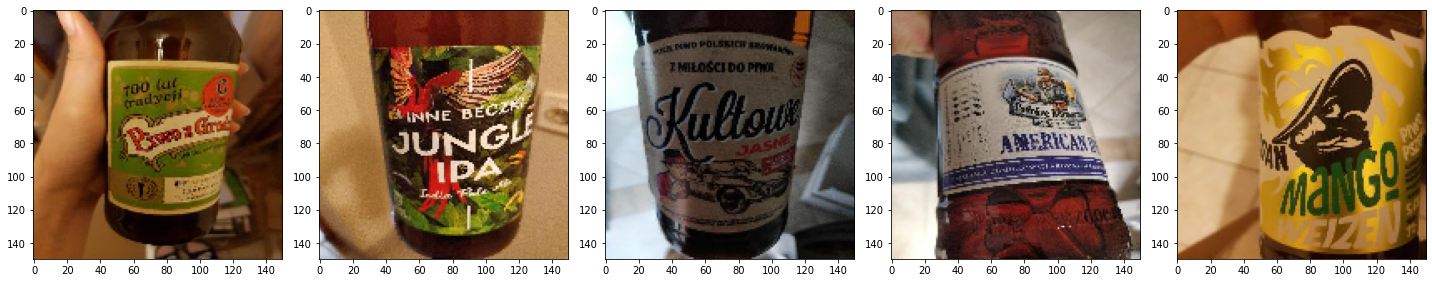

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [ ]:
test_image_generator = ImageDataGenerator(
    rescale=1./255
)
test_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                              class_mode='sparse')

Found 4910 images belonging to 100 classes.


> If we want with augmentation here do ...

In [ ]:
# augumentation

# Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

### Train the model

In [ ]:
EPOCHS = 8
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(batch_size)))
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/8
24/24 [==============================] - 19s 372ms/step - loss: 4.5592 - accuracy: 0.0277 - val_loss: 4.3170 - val_accuracy: 0.0679
Epoch 2/8
24/24 [==============================] - 8s 318ms/step - loss: 3.6292 - accuracy: 0.1910 - val_loss: 2.9660 - val_accuracy: 0.3249
Epoch 3/8
24/24 [==============================] - 8s 317ms/step - loss: 1.8477 - accuracy: 0.5311 - val_loss: 1.9670 - val_accuracy: 0.5393
Epoch 4/8
24/24 [==============================] - 8s 318ms/step - loss: 0.9081 - accuracy: 0.7549 - val_loss: 1.3975 - val_accuracy: 0.7071
Epoch 5/8
24/24 [==============================] - 8s 318ms/step - loss: 0.4081 - accuracy: 0.8892 - val_loss: 1.1997 - val_accuracy: 0.7337
Epoch 6/8
24/24 [==============================] - 8s 318ms/step - loss: 0.1821 - accuracy: 0.9467 - val_loss: 1.1061 - val_accuracy: 0.7790
Epoch 7/8
24/24 [==============================] - 8s 317ms/step - loss: 0.0895 - accuracy: 0.9766 - val_loss: 1.4478 - val_accuracy: 0.7843
Epoch 8/8
24

### Visualizing results of the training

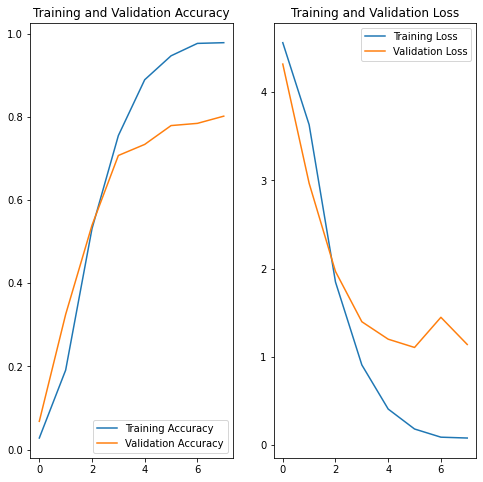

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

# Evaluation

In [ ]:
# Evaluate on Validation data
#scores = model.evaluate(test_data_gen)
#print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

test_loss, test_acc = model.evaluate_generator(test_data_gen)
print("%s%s: %.2f%%" % ("Test ",model.metrics_names[1], test_acc*100))
print("%s%s: %.2f%%" % ("Test ",model.metrics_names[0], test_loss*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """


Test accuracy: 83.10%
Test loss: 73.99%


# Prediction

In [ ]:
(test_data_gen.n)

4910

In [ ]:
test_data_gen.reset()

In [ ]:
prediction = model.predict(test_data_gen, steps = 
                                   np.ceil(test_data_gen.n/batch_size))

# Analize

In [ ]:
print(len(prediction))

4910


In [ ]:
prediction[0]

In [ ]:
prediction_labels = prediction.argmax(axis=-1)

In [ ]:
print(prediction_labels)

[ 0  0  0 ... 99 99 99]




---



List `labels` is list of labels in train dataset where labels are like 0,1,...,98,99. 

In [ ]:
labels=[]
class_number = 0 
for c in os.listdir(os.path.join('dataset','test')):
  for image in os.listdir(os.path.join('dataset','test',c)):
    labels.append(class_number)
  class_number+=1

In [ ]:
print(labels)
print(len(labels))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

And `class_names` is names of classes. For example if label in labels is 0 then class name is `class_names[0]` -> '5901549250329 - name after folder

In [ ]:
class_names = os.listdir('dataset/test')



---



Here we count how many was good and bad prediction was. 

In [ ]:
good=0
bad=0

for y,label in zip(prediction_labels, labels):
  if y==label:
    good+=1
  else:
    bad+=1
  

In [ ]:
print(good, ", ", bad) 

2516 ,  2394




---



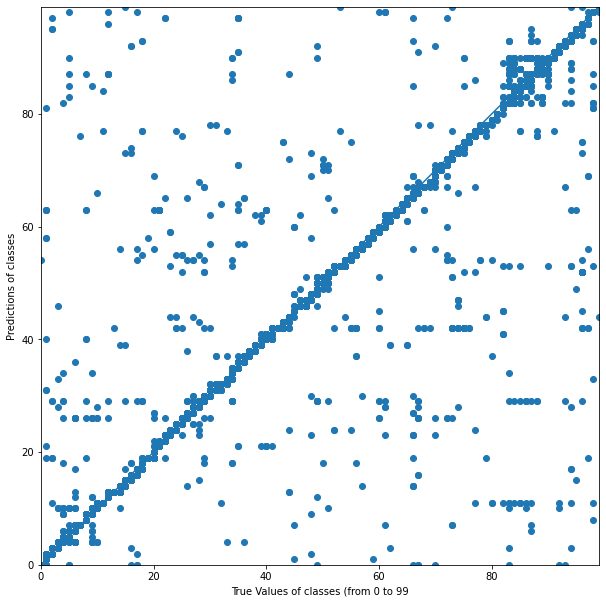

In [ ]:
a = plt.axes(aspect='equal')
plt.rcParams['figure.figsize'] = [50, 50]
plt.scatter(labels, prediction_labels)
plt.xlabel('True Values of classes (from 0 to 99')
plt.ylabel('Predictions of classes')
lims = [0, 99]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


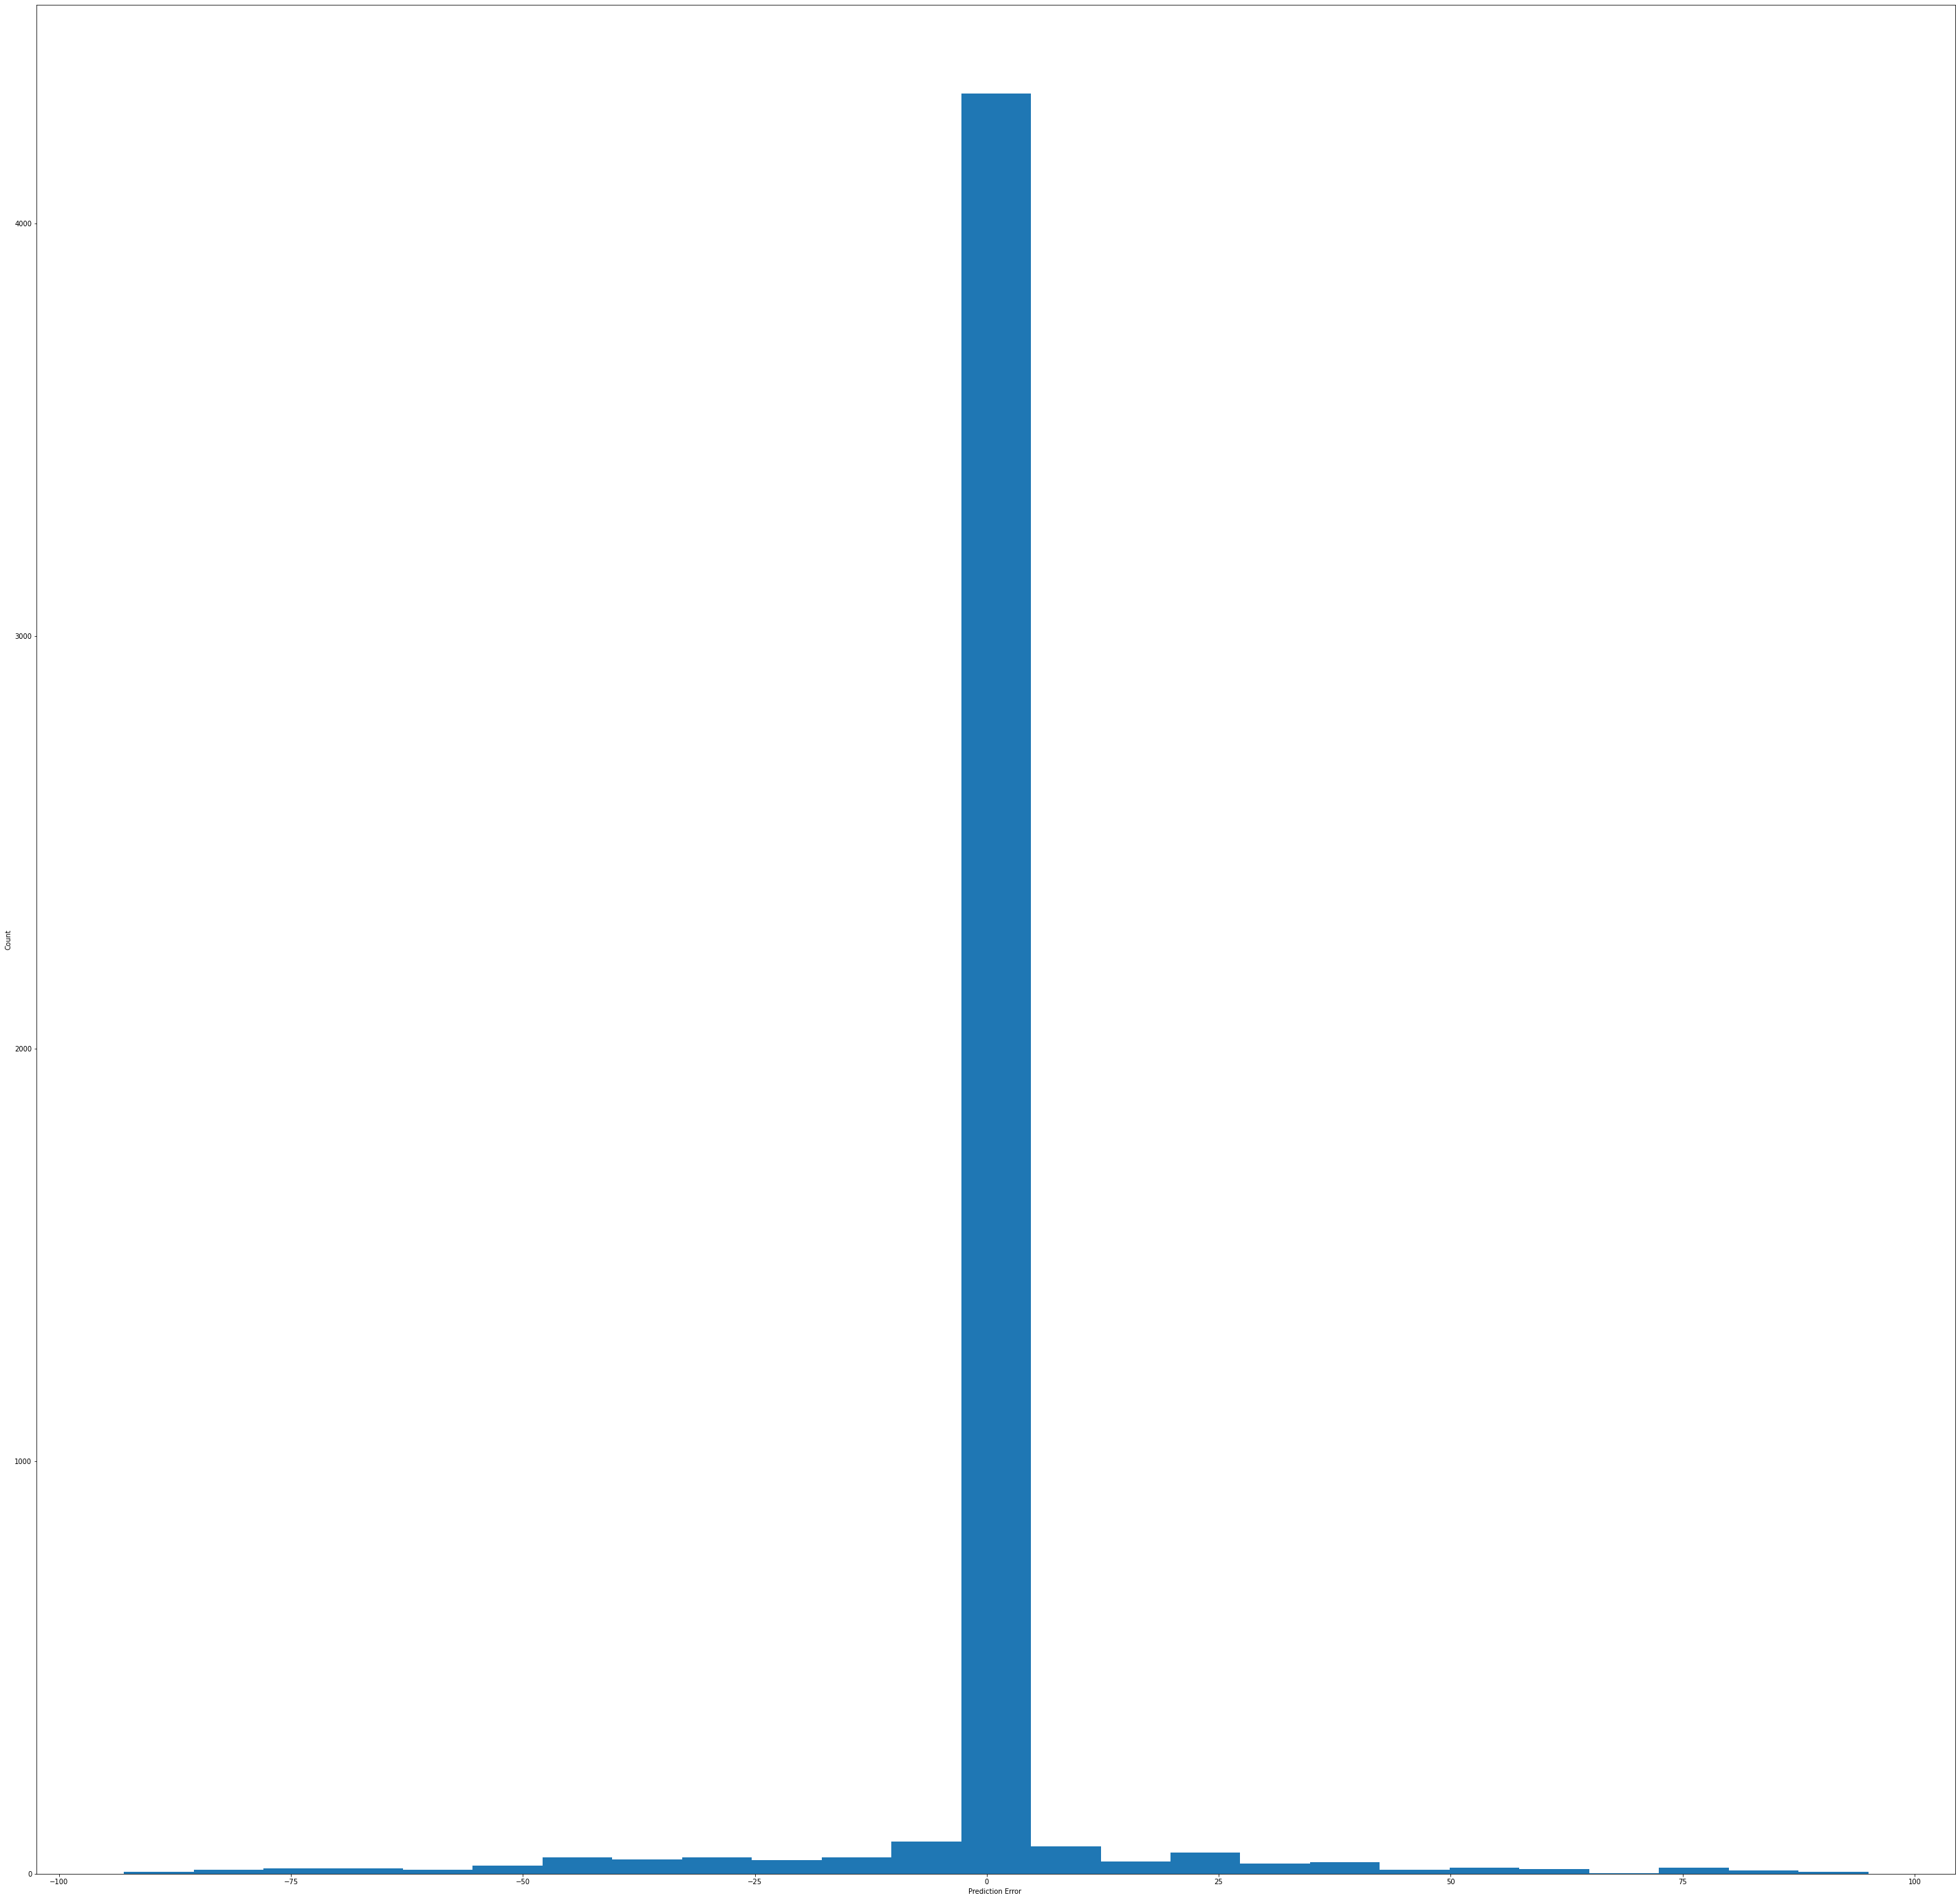

In [ ]:
#  rozkład błędów

error = prediction_labels - labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error ')
_ = plt.ylabel('Count')




---



Here we can see probability of every image from testing.
We count percent of good prediction for every class. 

In [ ]:
class_good_predictions=[0]*num_classes
for i, logits in enumerate(prediction):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  #print(class_idx) # przewidzaiana etykieta
  #print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))
  true_label=labels[i]
  #print("True label is {} prediction: {} ({:4.1f}%)".format(true_label, class_idx, 100*p))
  if 150<i<250:
    print("True label is {} prediction: {} ({:4.1f}%)".format(true_label, class_idx, 100*p))
  if true_label==class_idx:
    class_good_predictions[true_label]+=1

True label is 3 prediction: 3 (73.9%)
True label is 3 prediction: 33 (90.4%)
True label is 3 prediction: 3 (87.7%)
True label is 3 prediction: 46 (82.3%)
True label is 3 prediction: 3 (93.0%)
True label is 3 prediction: 3 (98.3%)
True label is 3 prediction: 28 (56.6%)
True label is 3 prediction: 3 (48.7%)
True label is 3 prediction: 3 (99.7%)
True label is 3 prediction: 3 (98.0%)
True label is 3 prediction: 3 (99.5%)
True label is 3 prediction: 3 (99.7%)
True label is 3 prediction: 3 (95.7%)
True label is 3 prediction: 3 (79.4%)
True label is 3 prediction: 3 (97.7%)
True label is 3 prediction: 3 (75.2%)
True label is 3 prediction: 3 (99.7%)
True label is 3 prediction: 3 (95.6%)
True label is 3 prediction: 3 (99.8%)
True label is 3 prediction: 3 (99.4%)
True label is 3 prediction: 3 (99.5%)
True label is 3 prediction: 3 (98.0%)
True label is 3 prediction: 3 (75.8%)
True label is 3 prediction: 3 (94.9%)
True label is 3 prediction: 3 (97.2%)
True label is 3 prediction: 3 (92.8%)
True labe

In [ ]:
print(class_good_predictions)

[51, 32, 26, 31, 20, 31, 14, 42, 38, 21, 23, 41, 34, 36, 38, 32, 36, 35, 39, 42, 35, 46, 18, 33, 27, 27, 26, 14, 11, 23, 14, 27, 27, 43, 31, 23, 28, 32, 27, 25, 29, 30, 43, 34, 37, 44, 37, 43, 38, 29, 29, 25, 32, 35, 48, 31, 21, 18, 13, 19, 14, 17, 33, 24, 11, 9, 6, 8, 0, 0, 18, 17, 14, 14, 22, 28, 30, 13, 4, 0, 0, 0, 1, 2, 3, 7, 16, 13, 21, 10, 33, 41, 19, 19, 26, 46, 13, 38, 37, 55]


In [ ]:
for a in range(len(class_good_predictions)):
  n=class_good_predictions[a]/labels.count(a)
  class_good_predictions[a]=n

In [ ]:
print(class_good_predictions)

[0.9807692307692307, 0.5714285714285714, 0.6046511627906976, 0.7209302325581395, 0.425531914893617, 0.6078431372549019, 0.32558139534883723, 0.9767441860465116, 0.6785714285714286, 0.4883720930232558, 0.5348837209302325, 0.9534883720930233, 0.6666666666666666, 0.972972972972973, 0.7307692307692307, 0.6274509803921569, 0.6923076923076923, 0.625, 0.6964285714285714, 0.9767441860465116, 0.6862745098039216, 0.8214285714285714, 0.32142857142857145, 0.7674418604651163, 0.574468085106383, 0.627906976744186, 0.4642857142857143, 0.25, 0.2558139534883721, 0.5348837209302325, 0.32558139534883723, 0.7297297297297297, 0.8181818181818182, 0.8431372549019608, 0.5535714285714286, 0.4107142857142857, 0.5, 0.5714285714285714, 0.5294117647058824, 0.49019607843137253, 0.5471698113207547, 0.6976744186046512, 1.0, 0.7906976744186046, 0.7872340425531915, 0.7857142857142857, 0.8604651162790697, 0.7678571428571429, 0.6785714285714286, 0.5178571428571429, 0.6744186046511628, 0.5813953488372093, 0.74418604651162

### NOT !!! We use [`np.argpartition`](https://numpy.org/doc/stable/reference/generated/numpy.argpartition.html) to find five lowest predicted classes.   
NOT WORKING SOMETHING IN ARGPARTION!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
'''
k=5  # how many classes we want to see /with the lower count good predctions/
x=np.array([i * 100 for i in class_good_predictions])

idx = np.argpartition(x, k)  #  It returns an array of indices of the same shape as a that index data along the given axis in partitioned order.
print(idx)
'''

[81 79 68 69 80 82 83 84 72 85 67 66 27 65 78 60 73 58 93 96 71 70 22 74
 77  6 86  4 28 87 30 64 63 61 89 35 59 57 94 39 40 41 95 43 44 45 49 47
 48  1 50 51 52 53 54 55 56 38 37 36 34 33 62 32 31 29 26 25 24 23 21 20
 18 17 16 75 76 15 14 97 12 11 10  9  8 98  5  3 88  2 90 91 92 46 99 42
 19 13  7  0]


In [ ]:
#print(x)

In [ ]:
#print(x[idx[:k]]) # This returns the k-smallest values. 
#print(x[idx[-k:]])  # and the higiest

[0. 0. 0. 0. 0.]
[100.          97.6744186   97.2972973   97.6744186   98.07692308]


In [ ]:
#names=os.listdir('beer_labels')
#print(names)

['5907688746143', '5905669086455', '5902528523311', '5904730284028', '5905669783095', '5903031401516', '5906874605066', '5905279965201', '5905279326224', '5902528999994', '5905669683012', '5906395497782', '5902528473449', '5903240674145', '5904730284561', '5903292264455', '5903111989835', '5907688746150', '5902528443251', '5906874605035', '5904730438605', '5904730465243', '5906591000663', '5906874605004', '5904730290074', '5907222604595', '5905669086233', '5903240674527', '5902448150178', '5901549250756', '5907431705083', '5906874605073', '5905669783033', '5905279959743', '5905669683647', '5905669783019', '5904730284035', '5905279959637', '5904730438001', '5906874346198', '5905279533264', '5905279533240', '5905669683005', '5904730438582', '5902931900310', '5905669479196', '5902528052347', '5905669479264', '5903240620142', '5905669542586', '5905279326262', '5902528573354', '5905279965454', '5903292264004', '5905669542722', '5907431705359', '5906874605059', '5905669897105', '590527921300

In [ ]:
'''
worst_trained = []
names=os.listdir('beer_labels')
for i in range(k):
  index=np.where(idx==int(num_classes -1 - i))[0][0]
  label_name = names [index]
  worst_trained.append(label_name)
print(worst_trained)
'''

['5907222039083', '5905912650020', '5905669511063', '5906874605035', '5905669683005']


^ NOT

---


### numpy.argsort


In [ ]:
k=5  # how many classes we want to see /with the lower count good predctions/
x=np.array([i * 100 for i in class_good_predictions])

worst_trained = []

for i in range(k):
  index = np.argsort(x)[i]
  #print(class_good_predictions[index])
  #print(class_names[index])
  worst_trained.append(class_names[index])

0.0
5903111989811
0.0
5906591001332
0.0
5905669511063
0.0
5906591001479
0.0
5907431705090


### top 5 worst tested VISUALIZE

In [ ]:
import random
import cv2

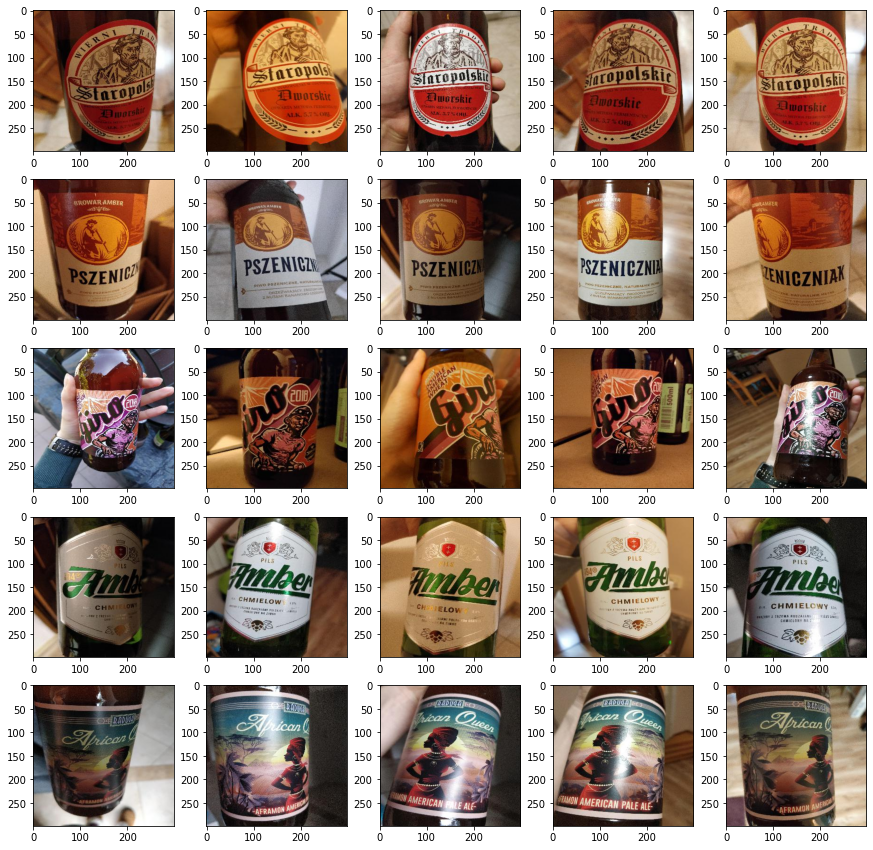

In [ ]:

fig, axes = plt.subplots(k,5, figsize=(15,15))

for i in range(k):
  list_of_pic_in_class = os.listdir(os.path.join('dataset','test', worst_trained[i]))  #'beer_labels' or in "dataset/test"
  for j in range(5):  # 5 img in class will be show
    img_name = list_of_pic_in_class[random.randint(0, len(list_of_pic_in_class)-1)]
    path = os.path.join('dataset','test',  worst_trained[i], img_name)

    img_read = cv2.imread(path)
    img_read=cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
    axes[i,j].imshow(img_read)

### What problem

Now we can see for each class what problem it can be..

In [ ]:
set_of_problems=dict()
for n in worst_trained:
  set_of_problems[n]=[]


for m in range(k):
  for i, logits in enumerate(prediction):
    class_idx = tf.argmax(logits).numpy()
    p = tf.nn.softmax(logits)[class_idx]
    name = class_names[class_idx]
    true_label=labels[i]
    true_name=class_names[true_label]
    #print("Example {} prediction: {} ({:4.1f}%)".format(true_label, name, 100*p))
    
    if true_name == worst_trained[m]:
      if name!=true_name:
        set_of_problems[true_name].append(name)


In [ ]:
print(set_of_problems)

{'5903111989811': ['5907637971480', '5907637971480', '5905279213210', '5905279213210', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5905669683005', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5905669683005', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480', '5907637971480'], '5906591001332': ['5907637971480', '5905669683005', '5905331025362', '5903111989811', '5903111989811', '5903111989811', '5903111989811', '5903111989811', '5903111989811', '5903111989811', '5903111989811', '5903111989811', '5903111989811', '590311198

In [ ]:
high_val = 0
for v in set_of_problems.values():
 if len(v)> high_val:
  high_val = len(v)
print(high_val)

56


In [ ]:
# ugly func
def visualize_img(imag, images=[], l=0):

  plt.figure(figsize=(10, 10))
  list_of_pic_in_class = os.listdir(os.path.join('dataset','test', imag))  #'beer_labels' or in "dataset/test"
  img_name = list_of_pic_in_class[random.randint(0, len(list_of_pic_in_class)-1)]
  path = os.path.join('dataset','test',  imag, img_name)
  img_read = cv2.imread(path)
  img_read=cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
  plt.imshow(img_read)

  fig, axes = plt.subplots(int(np.ceil(l/3)),3, figsize=(10,10))

  for ax, class_of_img in zip(axes.ravel(), images):
      
      list_of_pic_in_class = os.listdir(os.path.join('dataset','test', class_of_img))  #'beer_labels' or in "dataset/test"
      img_name = list_of_pic_in_class[random.randint(0, len(list_of_pic_in_class)-1)]
      path = os.path.join('dataset','test',  class_of_img, img_name)

      img_read = cv2.imread(path)
      img_read=cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)

      ax.imshow(img_read) 



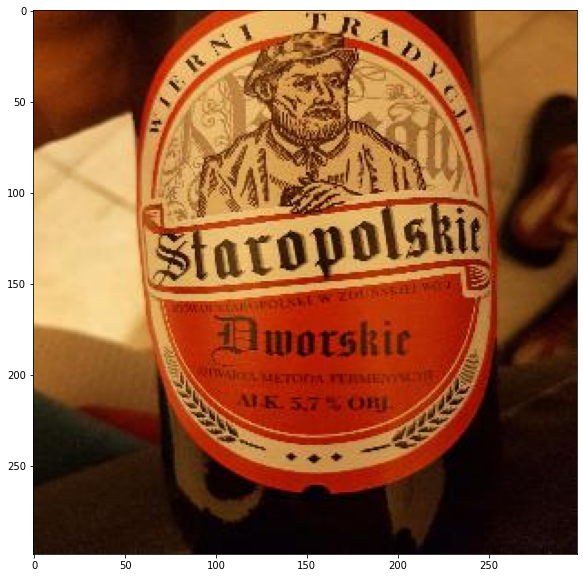

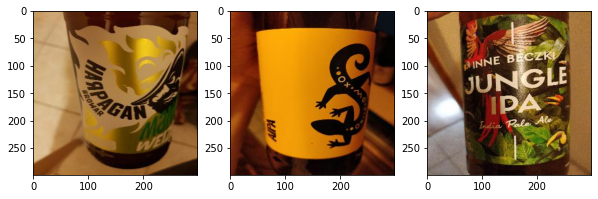

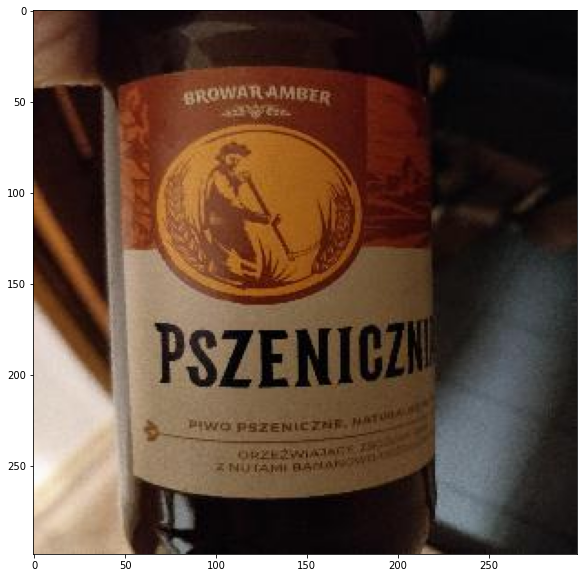

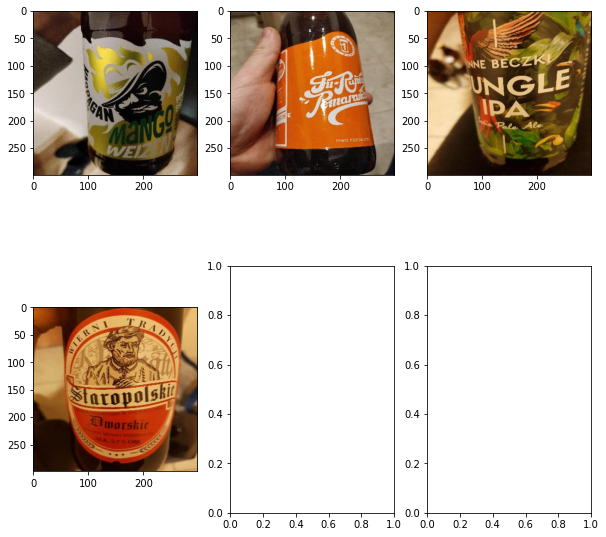

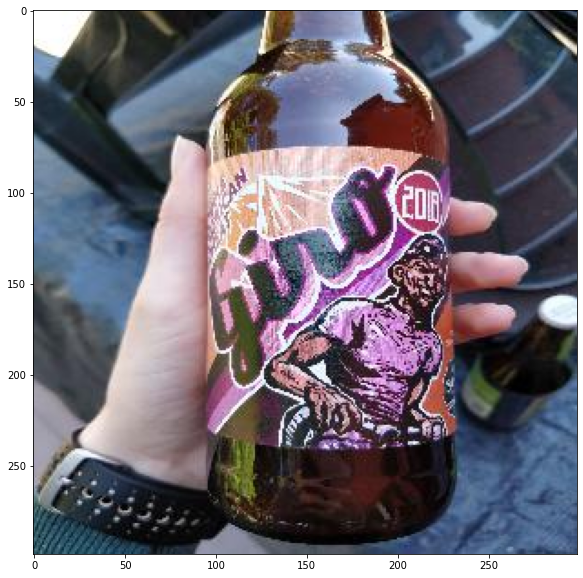

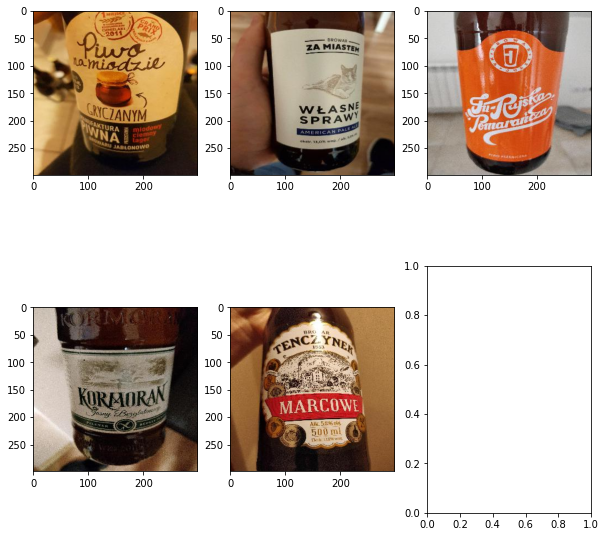

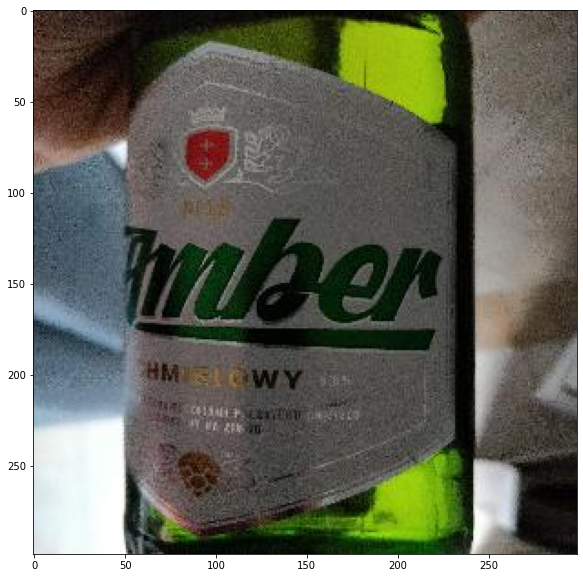

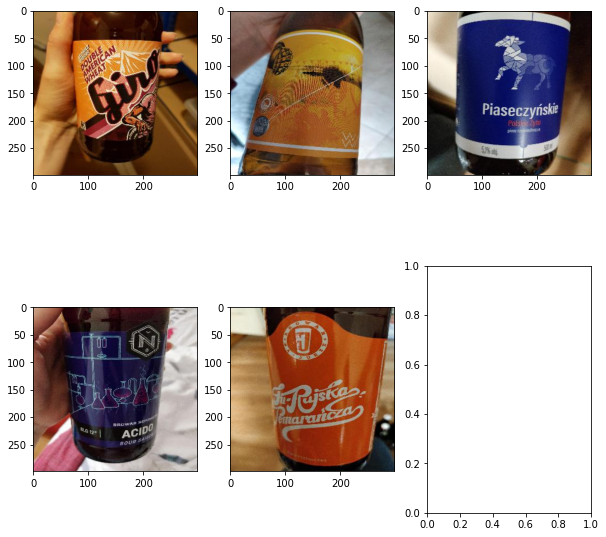

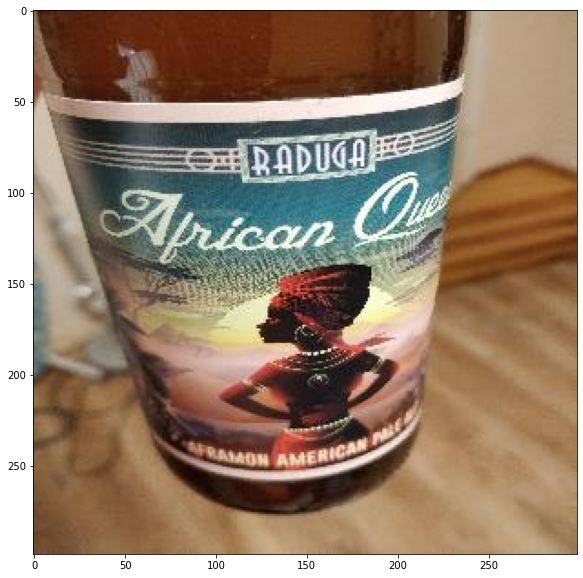

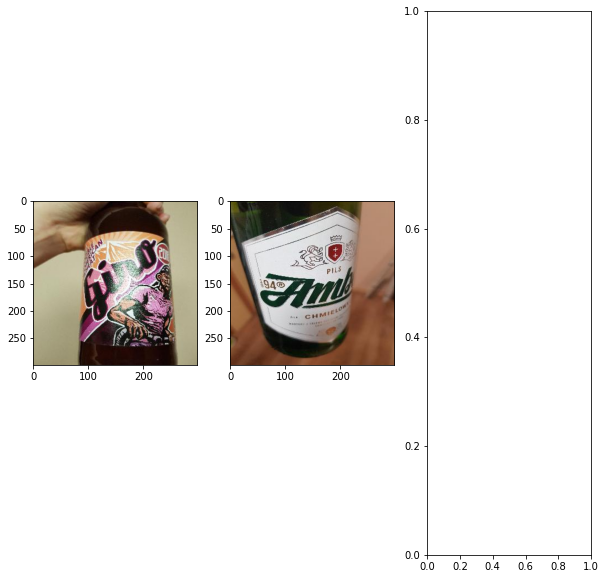

In [ ]:
for i in range(k):
  worst_img=worst_trained[i]
  conv_set = set(set_of_problems[worst_img])
  conv_list=list(conv_set)

  visualize_img(worst_img, conv_list, len(conv_list))

Can also count label which have the greatest value for each problematic beer..... and so on...

# UWAGI

https://sites.google.com/view/amarnath-r/keras-deep-learning-image-classification-a-simple-example

https://sites.google.com/view/amarnath-r/keras-deep-learning-image-classification-a-simple-example

https://www.tensorflow.org/lite/guide/inference